In [29]:
from TCFile import TCFile
import numpy as np
import torch
import cv2
from torchvision import models
import utils

def process(path, time, model, mini_model, crop_size=(160,160), adaptive_crop=False, overlap=True, stride_proportion=0.5,
            wanted_patches=[], background_vote=False):
    # Load                                                                                    & prep data
    file = TCFile(path, '2DMIP')
    crop_size = crop_size

    slice_2d = utils.resize_tomogram_mip(
        file[time],
        data_resolution=file.data_resolution,
        target_resolution=0.1632,
        mode='mip'
    )

    if adaptive_crop:
        # Adjust the patch size if you want the patches to fit the image nicely
        residual = slice_2d.shape[0] % crop_size[0]
        fit = slice_2d.shape[0] // crop_size[0]
        adapt = residual // fit if fit > 0 else 0
        crop_size = (crop_size[0] + adapt, crop_size[1] + adapt)
        stride = int(crop_size[0]*stride_proportion)

    base_image = slice_2d.copy()
    # base_image = utils.image_normalization(base_image, min=1.33, max=1.4)

    # Normal PyTorch model prep
    transform = models.ResNet101_Weights.IMAGENET1K_V2.transforms()
    mini_transform = models.ResNet50_Weights.IMAGENET1K_V2.transforms()

    model = model.cuda().eval()
    mini_model = mini_model.cuda().eval()

    # We'll store class votes for each pixel here: (H, W, num_classes)
    num_classes = 1+5  # Adjust if you actually have a different number
    label_counts = np.zeros((base_image.shape[0], base_image.shape[1], num_classes), dtype=np.int32)
    patch_layer = np.zeros((base_image.shape[0], base_image.shape[1]), dtype=np.int32)
    
    patch_coord = []
    wanted_patches = wanted_patches
    wanted_probabilities = []
    wanted_images = []
    
    if overlap:
        # Overlapping patches: define a smaller stride
        # e.g. half the patch size in each dimension
        stride_h = stride_w = stride
        patch_num = 0

        for top in range(0, base_image.shape[0] - crop_size[0] + 1, stride_h):
            for left in range(0, base_image.shape[1] - crop_size[1] + 1, stride_w):
                patch_coord.append((top, left, crop_size[0]))
                # Extract patch
                cropped = base_image[top:top+crop_size[0], left:left+crop_size[1]]

                # Clamp intensities (like your code)
                cropped = np.clip(cropped, 1.33, 1.40)
                cropped = utils.image_normalization(cropped, min=1.33, max=1.40)

                # Decide if we run the main model or the mini_model logic
                temp = cropped.copy()
                temp[temp < 45] = 0
                temp[temp > 45] = 1
                proportion = np.count_nonzero(temp == 1) / (np.count_nonzero(temp == 0) + np.count_nonzero(temp == 1))

                if proportion < 0.05:
                    # Use mini_model to check necrosis
                    mini_temp = cv2.equalizeHist(cropped.astype(np.uint8))
                    mini_temp = torch.from_numpy(mini_temp).repeat(3, 1, 1).float()
                    mini_temp = mini_transform(mini_temp).cuda()

                    is_necrosis = torch.max(mini_model(mini_temp.unsqueeze(0)), 1)[1].item()

                    if is_necrosis == 1:
                        # If necrosis, run the main model
                        image_tensor = torch.from_numpy(cropped).repeat(3, 1, 1).float()
                        image_tensor = transform(image_tensor).cuda()
                        output = model(image_tensor.unsqueeze(0)).cpu()
                        _, pred = torch.max(output, 1)
                        class_label = pred.item() + 1  # 0..(num_classes-1)
                    else:
                        class_label = 0  # or some "background" label
                else:
                    # Directly run main model
                    image_tensor = torch.from_numpy(cropped).repeat(3, 1, 1).float()
                    image_tensor = transform(image_tensor).cuda()
                    output = model(image_tensor.unsqueeze(0)).cpu()
                    _, pred = torch.max(output, 1)
                    class_label = pred.item() + 1
                    
                
                if patch_num in wanted_patches:
                    wanted_probabilities.append(output.detach().numpy())
                    wanted_images.append(base_image[top:top+crop_size[0], left:left+crop_size[1]])

                # Add a vote for this class in label_counts
                label_counts[top:top+crop_size[0], left:left+crop_size[1], class_label] += 1
                patch_layer[top:top+crop_size[0], left:left+crop_size[1]] = patch_num
                patch_num += 1
                
    else:
        # Original no-overlap approach
        patches = utils.crop_patch(slice_2d, crop_size=crop_size, overlap=False)
        patch_num = 0
        for patch_index, patch in enumerate(patches):
            top, left = patch[0], patch[1]
            patch_coord.append((top, left, crop_size[0]))
            cropped = base_image[top:top+crop_size[0], left:left+crop_size[1]]

            cropped = np.clip(cropped, 1.33, 1.40)
            cropped = utils.image_normalization(cropped, min=1.33, max=1.40)

            temp = cropped.copy()
            temp[temp < 45] = 0
            temp[temp > 45] = 1
            proportion = np.count_nonzero(temp == 1) / (np.count_nonzero(temp == 0) + np.count_nonzero(temp == 1))

            if proportion < 0.05:
                mini_temp = cv2.equalizeHist(cropped.astype(np.uint8))
                mini_temp = torch.from_numpy(mini_temp).repeat(3, 1, 1).float()
                mini_temp = mini_transform(mini_temp).cuda()
                is_necrosis = torch.max(mini_model(mini_temp.unsqueeze(0)), 1)[1].item()

                if is_necrosis == 1:
                    image_tensor = torch.from_numpy(cropped).repeat(3, 1, 1).float()
                    image_tensor = transform(image_tensor).cuda()
                    output = model(image_tensor.unsqueeze(0)).cpu()
                    _, pred = torch.max(output, 1)
                    class_label = pred.item() + 1
                else:
                    class_label = 0
            else:
                image_tensor = torch.from_numpy(cropped).repeat(3, 1, 1).float()
                image_tensor = transform(image_tensor).cuda()
                output = model(image_tensor.unsqueeze(0)).cpu()
                _, pred = torch.max(output, 1)
                class_label = pred.item() + 1
                
                
            if patch_num in wanted_patches:
                wanted_probabilities.append(output.detach().numpy())
                wanted_images.append(base_image[top:top+crop_size[0], left:left+crop_size[1]])
                
            label_counts[top:top+crop_size[0], left:left+crop_size[1], class_label] += 1
            patch_layer[top:top+crop_size[0], left:left+crop_size[1]] = patch_num
            patch_num += 1
    # Final pixelwise label = most frequent vote + 1 (if you want 1-based classes)
    # label_image = np.argmax(label_counts, axis=-1)
    
    # --- MODIFIED FINAL LABEL ASSIGNMENT ---
    # Final pixelwise label assignment with background priority

    # Calculate the standard argmax first (most frequent vote overall)
    provisional_label_image = np.argmax(label_counts, axis=-1)

    if background_vote:
        # Identify pixels where at least one patch voted for background (class 0)
        # label_counts[:, :, 0] accesses the counts for class 0 for all pixels
        total = np.sum(label_counts, axis=2)
        has_background_vote = 0.15 < label_counts[:, :, 0]/total

        # Initialize the final label image with the provisional result
        label_image = provisional_label_image.copy()

        # Override: wherever a background vote exists, set the final label to 0
        label_image[has_background_vote] = 0
        # --- END OF MODIFIED SECTION ---
    else:
        label_image = provisional_label_image.copy()

    return base_image, label_image, patch_layer, patch_coord, wanted_probabilities, wanted_images


In [55]:
from tqdm import tqdm
import torch
from torchvision import models
import utils
import numpy as np

path = r"C:\rkka_Projects\cell_death_v2\Data\9. A549_FasL(20250410)\250409.170229.A549_FasL_01.025.Group1.A4.T025P01.TCF"
class_num = 5
model_path = r"C:\rkka_Projects\cell_death_v2\trained_models\test_5_classes_22.032991_0.9728_sota.pth"
mini_model_path = r"C:\rkka_Projects\cell_death_v2\trained_models\mini_ai_epoch_9_0.000861_1.0000.pth"
file = TCFile(path, '2DMIP')
# Load Model
model = models.resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 5)
)
model.load_state_dict(torch.load(model_path))

# Load mini Model
mini_model = models.resnet50(pretrained=True)
num_features = mini_model.fc.in_features
mini_model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 2)
)
mini_model.load_state_dict(torch.load(mini_model_path))

# Process
base_stack = []
label_stack = []
probabilities_stack = []

# wanted_patches = [110, 334, 329, 258, 192]
# wanted_patches = [0]

# for i in tqdm(range(len(file))):
for i in tqdm(range(0, 55)):
    # base_image, label_image = process(path, i, model, mini_model, adaptive_crop=True)
    base_image, label_image, patch_layer, patch_coord, wanted_probabilities, wanted_images = process(path, i, model, mini_model, 
                                                                                                     crop_size=(160,160),
                                      adaptive_crop=True, overlap=True, stride_proportion=0.5, wanted_patches=[],
                                      background_vote=True)
    base_stack.append(base_image)
    label_stack.append(label_image)

c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-d

In [56]:
base_stack_array = np.array(base_stack)
label_stack_array = np.array(label_stack)

In [8]:
import napari
viewer = napari.Viewer()

In [57]:
viewer.add_image(base_stack_array)

colors = {1: '#FF9B9B', 2: '#FFD89C', 3: '#B99470', 4: '#3B6790', 5: "#98D8EF", 6 : "#BBD8A3"}
labels_layer = viewer.add_labels(label_stack_array.astype(int), colormap=colors)
labels_layer.color_mode = 'direct'

c:\miniconda3\envs\cell\Lib\site-packages\napari\utils\colormaps\colormap.py:435: UserWarning: color_dict did not provide a default color. Missing keys will be transparent. To provide a default color, use the key `None`, or provide a defaultdict instance.
  warn(


In [149]:
import napari
viewer = napari.Viewer()

In [61]:
path = r"C:\rkka_Projects\cell_death_v2\Data\8. A549 cell death(20250404)\250404.153021.A549_death_01_TNFa.001.Group4.C3.T001P05.TCF"
file = TCFile(path, '2DMIP')
image = np.array([f for f in file])
viewer.add_image(image)

<Image layer 'image' at 0x23a670b62d0>

In [154]:
path = r"C:\rkka_Projects\cell_death_v2\Data\8. A549 cell death(20250404)\250404.153021.A549_death_01_TNFa.001.Group4.C3.T001P01.TCF"
file = TCFile(path, '2DMIP')
image = np.array([utils.resize_tomogram_mip(f, data_resolution=file.data_resolution, target_resolution=0.1632, mode='mip') for f in file])
viewer.add_image(image)

<Image layer 'image' at 0x23a59855c10>

In [ ]:
necroptosis

In [1]:
from PIL import Image
import torch
import utils
from torchvision import models
from TCFile import TCFile
import numpy as np

model_path = r"C:\rkka_Projects\cell_death_v2\trained_models\resnet50_24.242485_0.9728.pth"
path = r"C:\rkka_Projects\cell_death_v2\Data\8. A549 cell death(20250404)\250404.153021.A549_death_01_TNFa.001.Group4.C3.T001P04.TCF"
# Load Model
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 5)
)
model.load_state_dict(torch.load(model_path))
model = model.cuda()

transform = models.ResNet50_Weights.IMAGENET1K_V2.transforms()
file = TCFile(path, '2DMIP')
time = 72
center = (734, 381)
a = []
for f in file:
    f = utils.resize_tomogram_mip(f, data_resolution=file.data_resolution, target_resolution=0.1632, mode='mip')
    f = utils.image_normalization(f, min=1.33, max=1.40)
    f = f[center[0]-80:center[0]+80, center[1]-80:center[1]+80]
    
    a.append(f)

a = np.array(a)
a = torch.from_numpy(a)

outputs = []
labels = []
with torch.no_grad():
    model = model.eval()
    for i in range(time,time+1):
        i = a[i].unsqueeze(0).repeat(3,1,1).float()
        i = transform(i)
        output = model(i.unsqueeze(0).cuda())
        outputs.append(output)
        labels.append(int(torch.max(output, 1)[1].cpu().numpy()[0]))
        
# 확률 계산산
import torch.nn.functional as F
with torch.no_grad():
    # output = torch.from_numpy(wanted_probabilities[0])
    # Apply softmax to get probabilities
    probabilities = []
    for output in outputs:
        probs = F.softmax(output.cpu(), dim=1)  # shape: [1, 5]
        # If you want it as a simple list or tensor
        probs = probs.squeeze()  # shape: [5]
        probs = probs.numpy()
        probabilities.append(probs)

# 확률 출력
probabilities

c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[array([0.25698334, 0.5505451 , 0.0170838 , 0.13861157, 0.03677618],
       dtype=float32)]

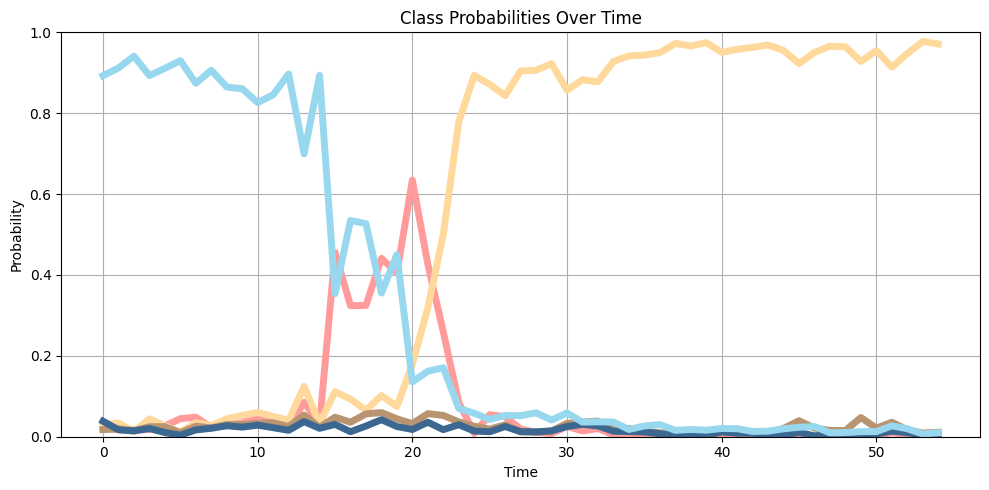

In [78]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))

# Example dummy data
class_names = ['Apoptosis', 'Necroptosis', 'Necrosis', 'Control', 'Treated yet Alive']
colors = {1: '#FF9B9B', 2: '#FFD89C', 3: '#B99470', 4: '#3B6790', 5: "#98D8EF"}

for i, class_name in enumerate(class_names):
    color = colors[i + 1]
    plt.plot(np.array(probabilities)[:, i], label=class_name, color=color, linewidth=5)

plt.title("Class Probabilities Over Time")
plt.xlabel("Time")
plt.ylabel("Probability")
plt.ylim(0, 1)
# plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
